In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

# Load the dataset
df = pd.read_csv('../data_processed/large_reddit_labelled.csv')  # Replace with your file path

# Check the first few rows of the dataset
print(df.shape)


(26000, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["combined"], df["category"], test_size=0.2, random_state=42)

In [6]:
train_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)


In [7]:
train_dataset = train_dataset.rename(columns={'category': 'label', 'combined':'text'})
test_dataset = test_dataset.rename(columns={'category': 'label', 'combined':'text'})


In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

In [9]:
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 5200/5200 [00:05<00:00, 899.05 examples/s]


In [10]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# %% [markdown]
# Load Pretrained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# %% [markdown]
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",          # Directory for saved models
    evaluation_strategy="epoch",    # Evaluate every epoch
    learning_rate=2e-5,             # Learning rate
    per_device_train_batch_size=16, # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    num_train_epochs=3,             # Number of epochs
    weight_decay=0.01,              # Apply weight decay
    logging_dir='./logs',           # Directory for logging
    logging_steps=10,
    save_total_limit=1              # Save only the best checkpoint
)

# %% [markdown]
# Trainer Object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# %% [markdown]
# Train the Model
trainer.train()

# %% [markdown]
# Evaluate the Model


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arko/VSC/NLP_ECE684/final_project/venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_123647/504115526.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.329400,0.299135
2,0.281600,0.327461
3,0.121000,0.380121


TrainOutput(global_step=3900, training_loss=0.2508786639341941, metrics={'train_runtime': 819.8257, 'train_samples_per_second': 76.114, 'train_steps_per_second': 4.757, 'total_flos': 2066491419033600.0, 'train_loss': 0.2508786639341941, 'epoch': 3.0})

In [11]:
trainer.evaluate()

{'eval_loss': 0.38012105226516724,
 'eval_runtime': 17.2792,
 'eval_samples_per_second': 300.94,
 'eval_steps_per_second': 18.809,
 'epoch': 3.0}

In [12]:
predictions = trainer.predict(test_dataset)


In [13]:
import numpy as np
y_preds = np.argmax(predictions.predictions, axis=1)


              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      2513
    Positive       0.90      0.89      0.90      2687

    accuracy                           0.89      5200
   macro avg       0.89      0.89      0.89      5200
weighted avg       0.89      0.89      0.89      5200



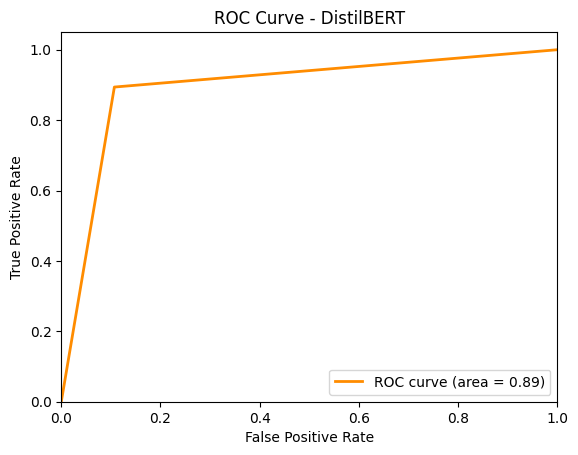

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print(classification_report(y_test, y_preds, target_names=['Negative', 'Positive']))

# %% [markdown]
# Plot ROC Curve for DistilBERT
fpr, tpr, _ = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DistilBERT')
plt.legend(loc="lower right")
plt.show()

In [25]:
predict_df = pd.read_csv('../data_processed/reddit_rising.csv')  # Replace with your file path
predict_dataset = predict_df.rename(columns={'combined':'text'})

In [26]:
predict_dataset

,Unnamed: 0,team,text
0,0,Arsenal,https://preview.redd.it/1635kl3dib3e1.jpeg?wid...
1,1,Arsenal,"Loved that from big Gabi, our Brazilian king i..."
2,2,Arsenal,PUT IT ON A T-SHIRT\n\n![gif](giphy|3o8doT9BL7...
3,3,Arsenal,An instant classic
4,4,Arsenal,Haha i love this
...,...,...,...
12050,12050,Southampton,"PAUL great to see you, how’s the weather up th..."
12051,12051,Southampton,"*""Think you're the only struggling club out th..."
12052,12052,Southampton,We appreciate your service. I've even turned o...
12053,12053,Southampton,Yeah… according to Alfie House on the echo it’...


In [27]:
predict_dataset = Dataset.from_pandas(predict_dataset)


In [28]:
predict_dataset

Dataset({
    features: ['Unnamed: 0', 'team', 'text'],
    num_rows: 12055
})

In [29]:
predict_dataset = predict_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(predict_dataset)


Map: 100%|██████████| 12055/12055 [00:14<00:00, 806.33 examples/s]


In [31]:
y_preds = np.argmax(predictions.predictions, axis=1)


In [37]:
predict_df["category"] = y_preds

In [ ]:
predict_df = predict_df.groupby("team")["category"].mean()

team
Arsenal              0.775934
Aston Villa          0.682081
Bournemouth          0.783920
Brentford            0.736641
Brighton             0.820669
Chelsea              0.778523
Crystal Palace       0.776316
Everton              0.631258
Fulham               0.568905
Ipswich Town         0.740088
Leicester City       0.561983
Liverpool            0.615605
Man City             0.596692
Man United           0.568584
Newcastle            0.517703
Nottingham Forest    0.621677
Southampton          0.533333
Tottenham            0.693164
West Ham             0.624535
Wolves               0.713287
Name: category, dtype: float64